In [1]:
# Figure 1

In [2]:
import re
import warnings

import cmaps 
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from gcpy import single_panel 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np 
import regionmask
import scipy.stats as stats
from scipy.stats import gmean, gstd
import seaborn as sns 
import xarray as xr 

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Load observations: June 
months = [6,6,6]
daily_mda8o3_ar6_ena = tools.get_observed_daily_mda8o3_ar6_afternoon("ENA", months[0], criteria=90, min_hour='12:00', max_hour='17:00')
daily_mda8o3_ar6_wce = tools.get_observed_daily_mda8o3_ar6_afternoon("WCE", months[1], criteria=90, min_hour='12:00', max_hour='17:00')
daily_mda8o3_ar6_eas = tools.get_observed_daily_mda8o3_ar6_afternoon("EAS", months[2], criteria=90, min_hour='12:00', max_hour='17:00')

In [4]:
# Load observations: August 
months = [8,8,8]
daily_mda8o3_ar6_ena2 = tools.get_observed_daily_mda8o3_ar6_afternoon("ENA", months[0], criteria=90, min_hour='12:00', max_hour='17:00')
daily_mda8o3_ar6_wce2 = tools.get_observed_daily_mda8o3_ar6_afternoon("WCE", months[1], criteria=90, min_hour='12:00', max_hour='17:00')
daily_mda8o3_ar6_eas2 = tools.get_observed_daily_mda8o3_ar6_afternoon("EAS", months[2], criteria=90, min_hour='12:00', max_hour='17:00')

In [5]:
# Original simulations
def get_original_values_diff(variable, sim, sim_SNOx, conversion_factor=1, resolution='c48'):
    ds = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{sim}.MDA8_O3.april-august.nc4")
    ds_SNOx = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{sim_SNOx}.MDA8_O3.april-august.nc4")

    ds_diff = ds_SNOx-ds

    da = ds_diff[variable]*conversion_factor
    
    if "lev" in da.dims:
        da = da.isel(lev=0)
    da_monthly = da.resample(time='1M').mean(dim='time')
    da_monthly_noland = tools.mask_ocean_c48(da_monthly)
    return da_monthly_noland


In [6]:
def get_sensitivity_diff_values(variable, simulation, simulation_SNOx, year, conversion_factor=1, resolution='c48'):
    ds = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{simulation}.MDA8_O3.april-august.{year}.nc4")
    print(ds)
    ds_SNOx = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{simulation_SNOx}.MDA8_O3.april-august.{year}.nc4")
    print(ds_SNOx)
    ds_diff = ds_SNOx-ds

    da = ds_diff[variable]*conversion_factor
    if "lev" in da.dims:
        da = da.isel(lev=0)
    da_monthly = da.resample(time='1M').mean(dim='time')
    if resolution=='c90':
        da_monthly_noland = tools.mask_ocean_c90(da_monthly)
    elif resolution=='c48':
        da_monthly_noland = tools.mask_ocean_c48(da_monthly)
    return da_monthly_noland

In [7]:
def quantile_error(data):
    central = np.mean(data)  # Central value (mean)
    lower = np.quantile(data, 0.025)
    upper = np.quantile(data, 0.975)
    return [central - lower, upper - central]  # Negative and positive errors

In [8]:
ar6_region = {
        "ENA": 5,
        "EAS": 58,
        "WCE": 17,
    }

In [9]:
def calculate_regional_mean_std(da, months, region, resolution='c48'):
    """
    Calculate the mean and standard deviation for a specific region and month.
    """
    if resolution == 'c48':
        cropped_da = tools.crop_regionmask_ar6_c48(da, region_num=ar6_region[region])
    elif resolution == 'c90':
        cropped_da = tools.crop_regionmask_ar6_c90(da, region_num=ar6_region[region])
    elif resolution == 'latlon':
        cropped_da = crop_regionmask_ar6(da, region_num=ar6_region[region])

    subset = cropped_da.sel(time=cropped_da.time.dt.month.isin(months))
    seasonal_mean = subset.resample(time='1Y').mean()

    if 'nf' in seasonal_mean.dims:
        regional_mean = seasonal_mean.mean(dim=['nf', 'Ydim', 'Xdim'])
    if 'lat' in seasonal_mean.dims:
        regional_mean = seasonal_mean.mean(dim=['lat', 'lon'])
    mean = regional_mean.mean().values
    std = quantile_error(regional_mean.values)
    return mean, std

In [10]:
def extract_means(dataset_name):
    """Returns a tuple of mean values (index=0) for each region."""
    return tuple(results[dataset_name][f"{region}"][0] for region in regions)

def extract_stds(dataset_name):
    """Returns a tuple of std values (index=1) for each region."""
    return tuple(results[dataset_name][f"{region}"][1] for region in regions)

In [11]:
def reshape_data(data):
    """
    Reshapes a list of pairs into a 2D array with separate lists for each index.

    Parameters:
    data (list of list): A list of pairs, where each pair is [x, y].

    Returns:
    list of list: A 2D array where the first row contains all first elements of the pairs
                  and the second row contains all second elements.
    """
    # Transpose the data using zip
    reshaped = [list(i) for i in zip(*data)]
    return reshaped

In [12]:
# Part 1: Afternoon Ozone Evaluation: obs, cam, m2

# Afternoon Ozone
M2_for_observations  = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.M2_ref_c48.daily_LT_o3.june.august.nc4")
CAM_for_observations = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_ref_c48.daily_LT_o3.june.august.nc4")
all_observations = [daily_mda8o3_ar6_ena, daily_mda8o3_ar6_wce, daily_mda8o3_ar6_eas,
                            daily_mda8o3_ar6_ena2, daily_mda8o3_ar6_wce2, daily_mda8o3_ar6_eas2]


In [13]:
# Part 2: Spatial Ozone Response Comparison: cam vs m2
variable = "SpeciesConc_O3"
variable_string = "dO3/dENOx"

CAM_response = get_original_values_diff(variable, "all_ref_c48", "all_refSNOx_c48", conversion_factor=1e9, resolution='c48')
M2_response = get_sensitivity_diff_values(variable, "M2_ref_c48", "M2_refSNOx_c48", year=2014, conversion_factor=1e9, resolution='c48')

<xarray.Dataset>
Dimensions:         (time: 153, Xdim: 48, Ydim: 48, nf: 6)
Coordinates:
  * time            (time) datetime64[ns] 2014-04-01 2014-04-02 ... 2014-08-31
  * Xdim            (Xdim) float64 305.8 307.4 309.0 310.6 ... 31.01 32.63 34.21
  * Ydim            (Ydim) float64 -44.21 -42.62 -41.01 ... 41.01 42.62 44.21
  * nf              (nf) int32 1 2 3 4 5 6
    lons            (nf, Ydim, Xdim) float32 ...
    lats            (nf, Ydim, Xdim) float32 ...
Data variables:
    SpeciesConc_O3  (time, nf, Ydim, Xdim) float64 ...
Attributes:
    additional_vars:      contacts,orientation,anchor
    file_format_version:  2.90
    grid_mapping_name:    gnomonic cubed-sphere
    gridspec_file:        C48_gridspec.nc4
    long_name:            Daily maximum 8-hour mean
<xarray.Dataset>
Dimensions:         (time: 153, Xdim: 48, Ydim: 48, nf: 6)
Coordinates:
  * time            (time) datetime64[ns] 2014-04-01 2014-04-02 ... 2014-08-31
  * Xdim            (Xdim) float64 305.8 307.4 309.0 

In [14]:
# Part 3: Regional Mean Ozone Response Comparison: cam vs m2
datasets = {
    "ref": {
        "data": CAM_response,
    },
    "refM2": {
        "data": M2_response,
    }
}

comparison_months = [4,5,6,7,8]
regions = ["ENA", "WCE", "EAS"]

results = {}
for ds_name, ds_info in datasets.items():
    ds_data = ds_info["data"]
    results[ds_name] = {}
    for region in regions:
        result_key = f"{region}"  # e.g. "ENA"
        results[ds_name][result_key] = calculate_regional_mean_std(
                ds_data, comparison_months, region
            )

In [15]:
# Part 3: Regional Mean Ozone Response Comparison: cam vs m2
ref_mean        = extract_means("ref")
refM2_mean      = extract_means("refM2")

ref_std          = extract_stds("ref")
refM2_std        = extract_stds("refM2")

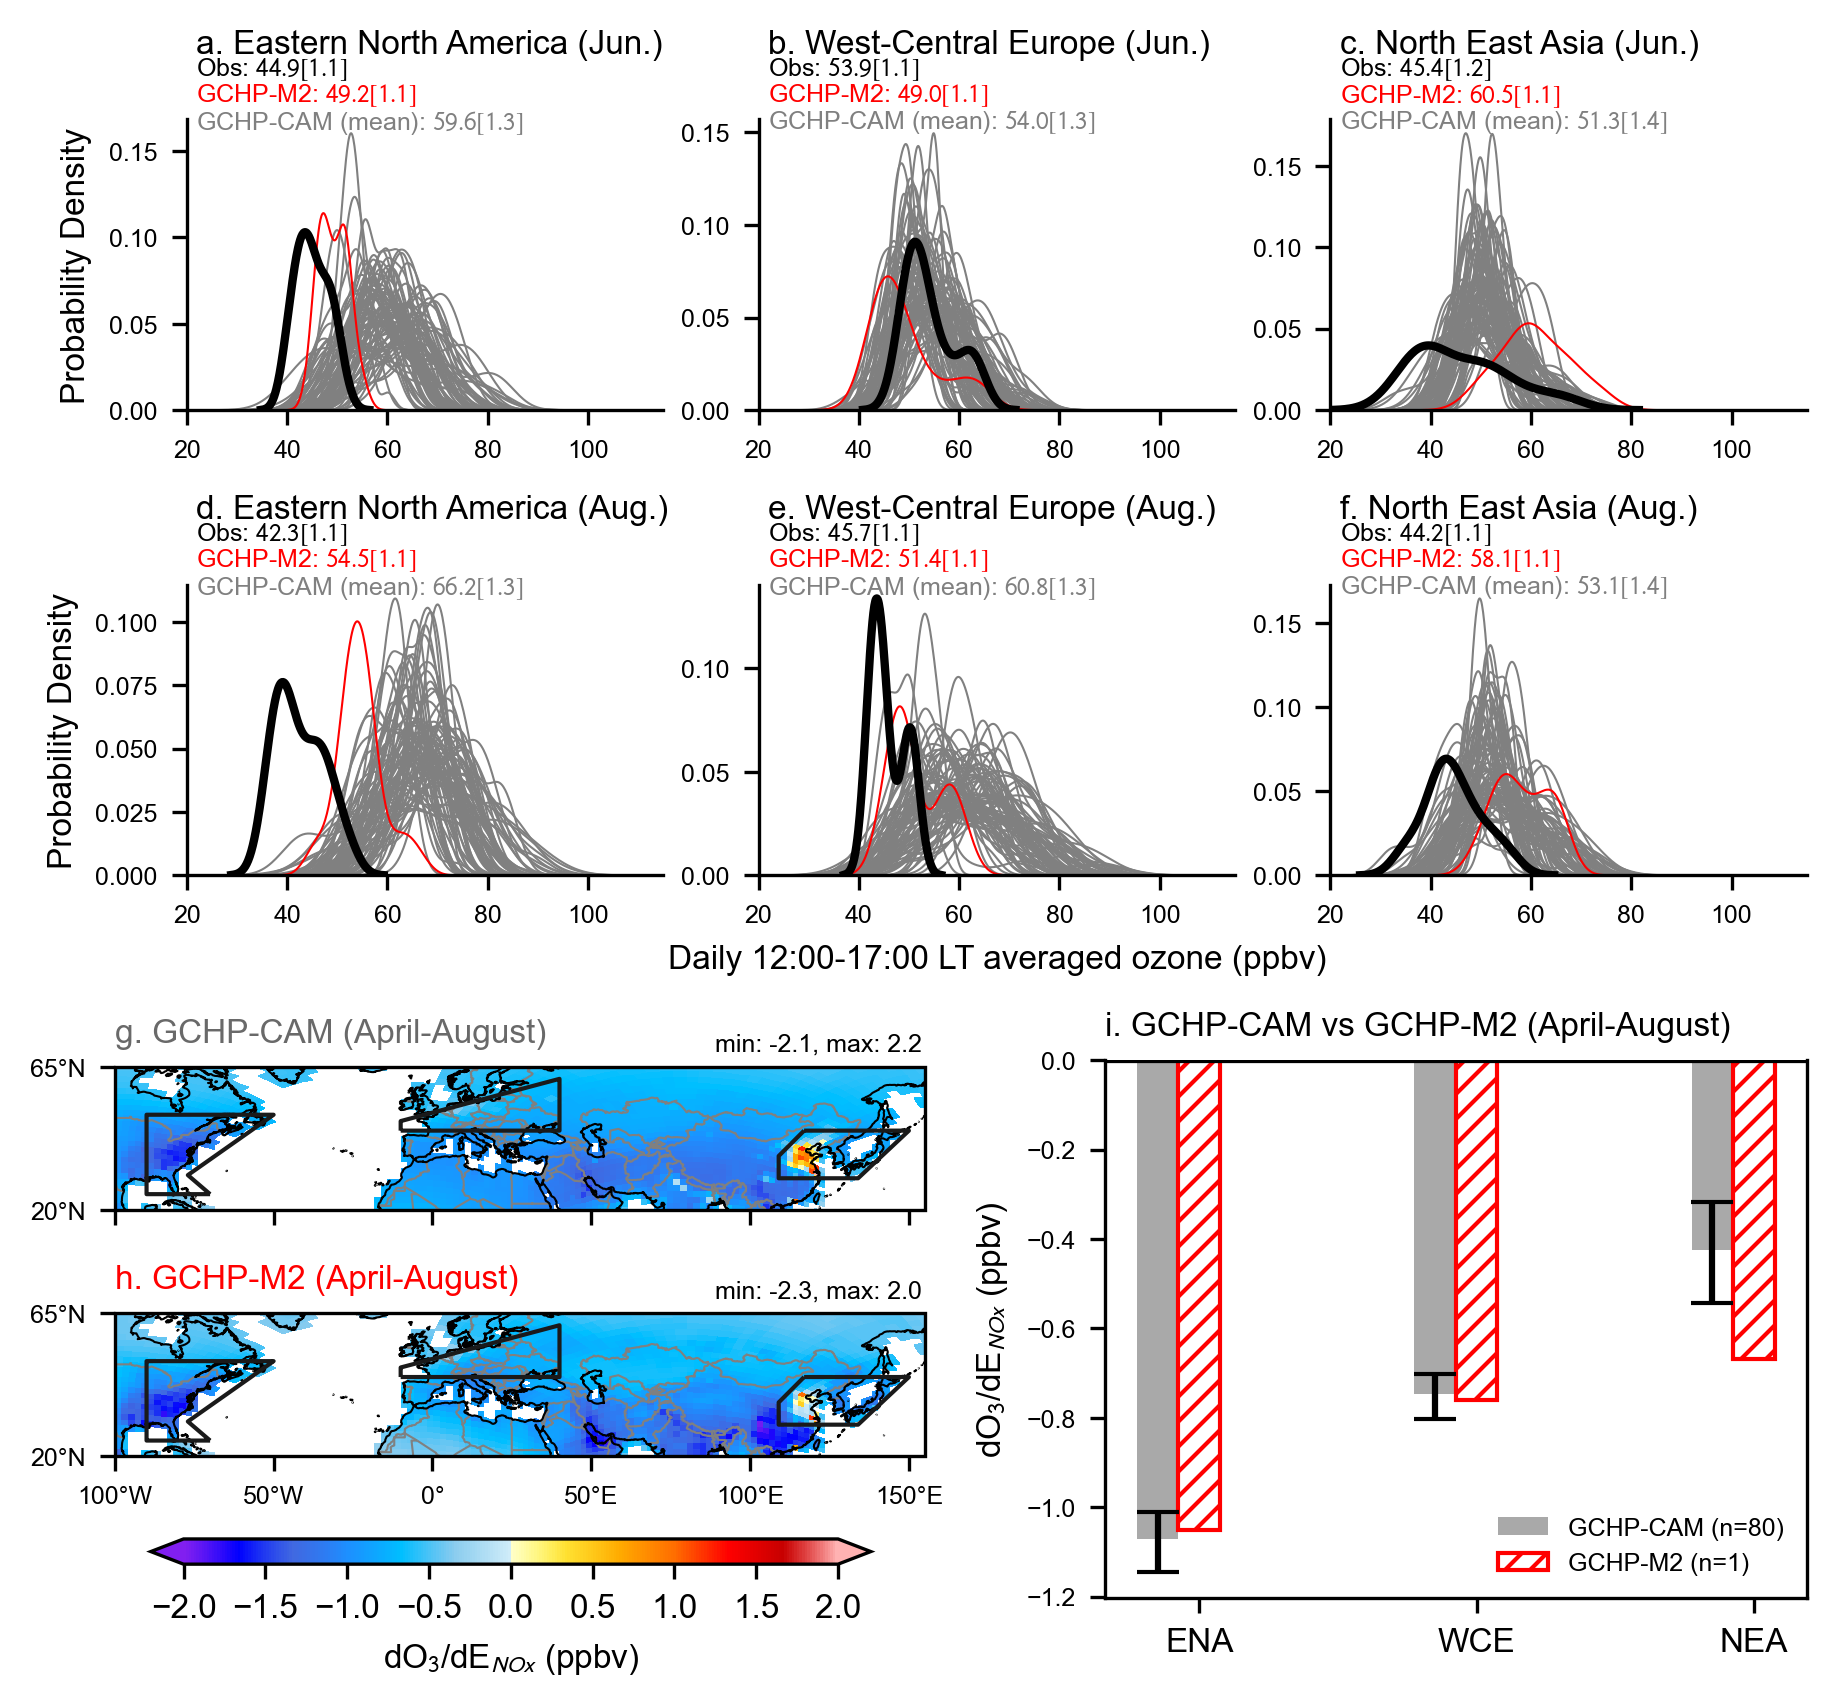

In [16]:
# Plot figure
tools.set_matplotlib_font("Arial")
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
    
color = 'black'

mpl.rcParams.update({
    'axes.edgecolor': color,      # Color of the axes spines
    'xtick.color': color,         # Color of the x-axis ticks
    'ytick.color': color,         # Color of the y-axis ticks
    'xtick.labelcolor': color,    # Color of the x-axis tick labels
    'ytick.labelcolor': color,    # Color of the y-axis tick labels
    'grid.color': color,          # Color of the grid lines
    'axes.labelcolor': color,     # Color of the axis labels
    'axes.titlecolor': color,     # Color of the plot titles
})

mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_in = 6
fig_height_in = 5.6

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)

gs1 = GridSpec(2, 3, top=0.94, bottom=0.49, left=0.09, right=0.99, hspace=0.6, wspace=0.2)
ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[0, 2])
ax4 = fig.add_subplot(gs1[1, 0])
ax5 = fig.add_subplot(gs1[1, 1])
ax6 = fig.add_subplot(gs1[1, 2])

gs2 = GridSpec(2, 1, top=0.40, bottom=0.12, left=0.05, right=0.50, hspace = 0.10, wspace=0.05)
ax7 = fig.add_subplot(gs2[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax8 = fig.add_subplot(gs2[1, 0], projection=ccrs.PlateCarree(central_longitude=0))

gs3 = GridSpec(1, 1, top=0.38, bottom=0.06, left=0.60, right=0.99, hspace = 0.30, wspace=0.05)
ax9 = fig.add_subplot(gs3[0, 0])

#################################################################################
## Part 1: Distributional evaluation of daily ozone: observations, cam, m2 ##

ax = [ax1, ax2, ax3, ax4, ax5, ax6]

titles= ["a. Eastern North America (Jun.)", "b. West-Central Europe (Jun.)", "c. North East Asia (Jun.)",
         "d. Eastern North America (Aug.)", "e. West-Central Europe (Aug.)", "f. North East Asia (Aug.)"]
observation_months = [6,6,6, 8,8,8]

GCHP_CAM_values = []
GCHP_M2_values = []

for idx, data in enumerate(all_observations):
    sitemean_mda8o3_ar6 = data.groupby("SITE_ID").mean()
    observation_mask = tools.get_observation_mask(sitemean_mda8o3_ar6)
    
    da_M2 = tools.get_masked_model_mda8o3(M2_for_observations, observation_mask, observation_months[idx])
    GCHP_M2_mean = da_M2.mean(dim=['nf', 'Ydim', 'Xdim'])
    GCHP_M2_values.append(GCHP_M2_mean)

    da_CAM = tools.get_masked_model_mda8o3(CAM_for_observations, observation_mask, observation_months[idx])
    GCHP_CAM_mean = da_CAM.mean(dim=['nf', 'Ydim', 'Xdim'])
    
    ###################
    means_ref = []
    stds_ref = []
    for sim in range(5):
        GCHP_sim_ref = GCHP_CAM_mean.isel(sim=sim)
        for year in range(2000, 2016): 
            GCHP_year_ref = GCHP_sim_ref.sel(time=GCHP_sim_ref.time.dt.year == year)
            sns.distplot(GCHP_year_ref, ax=ax[idx], hist=False, kde=True, kde_kws={'linewidth': 0.5}, color="grey")
            GCHP_CAM_values.append(GCHP_year_ref)

            if np.isnan(GCHP_year_ref.mean().values.item()):
                print(sim)
                print(year)
            else:
                means_ref.append(GCHP_year_ref.mean().values.item())
                stds_ref.append(GCHP_year_ref.std().values.item())

    model_mean_ref = np.mean(means_ref)
    model_geomean_ref = gmean(means_ref)
    model_std_ref = np.mean(stds_ref)
    model_geostd_ref = gstd(stds_ref)

    formatted_mmean_ref = format(model_mean_ref, ".1f")
    formatted_geommean_ref = format(model_geomean_ref, ".1f")
    formatted_mstdv_ref = format(model_std_ref, ".1f")
    formatted_geomstdv_ref = format(model_geostd_ref, ".1f")

    mtext_ref = r'GCHP-CAM (mean): ' + rf'${formatted_geommean_ref} [{formatted_geomstdv_ref}]$'

    ###################
    # Plot the distribution for each simulation and each year

    sns.distplot(GCHP_M2_mean, ax=ax[idx], hist=False, kde=True, kde_kws={'linewidth': 0.5}, color="red")
    model_mean = np.mean(GCHP_M2_mean.values)
    model_geomean = gmean(GCHP_M2_mean.values)
    model_std = np.std(GCHP_M2_mean.values)
    model_geomstd = gstd(GCHP_M2_mean.values)
    
    formatted_mmean = format(model_mean, ".1f")
    formatted_mgeommean = format(model_geomean, ".1f")
    formatted_mstdv = format(model_std, ".1f")
    formatted_mgeomstdv = format(model_geomstd, ".1f")

    # Plotting the distribution of the daily data mean
    daily_mean = data.groupby(['DATE']).mean()['O3_mda8']
    sns.distplot(daily_mean, ax=ax[idx], hist=False, kde=True, kde_kws={'linewidth': 2}, color='k')

    obs_mean = np.mean(daily_mean)
    obs_geommean = gmean(daily_mean)
    obs_std = np.std(daily_mean)
    obs_geomstd = gstd(daily_mean)
    
    formatted_omean = format(obs_mean, ".1f")
    formatted_ogeommean = format(obs_geommean, ".1f")
    formatted_ostdv = format(obs_std, ".1f")
    formatted_ogeomstdv = format(obs_geomstd, ".1f")

    mtext = r'GCHP-M2: ' + rf'${formatted_mgeommean} [{formatted_mgeomstdv}]$'
    otext = r'Obs: ' + rf'${formatted_ogeommean} [{formatted_ogeomstdv}]$'

    ax[idx].text(.02, 1.04, mtext_ref, ha='left', va='top', transform=ax[idx].transAxes, color='grey', fontsize=6)
    ax[idx].text(.02, 1.13, mtext, ha='left', va='top', transform=ax[idx].transAxes, color='red', fontsize=6)
    ax[idx].text(.02, 1.22, otext, ha='left', va='top', transform=ax[idx].transAxes, color='black', fontsize=6)
    ax[idx].text(.02, 1.31, titles[idx], ha='left', va='top', transform=ax[idx].transAxes, color='black', fontsize=8)

    ax[idx].spines[['right', 'top']].set_visible(False)

    if idx <3:
        ax[idx].set_xlim([20, 115])
    else:
        ax[idx].set_xlim([20, 115])

    ax[idx].spines[['right', 'top']].set_visible(False)
    ax[idx].set_xlabel(None)
    ax[idx].set_ylabel(None)

xlabel = "Daily 12:00-17:00 LT averaged ozone (ppbv)"
ax5.set_xlabel(xlabel, fontsize=8)

ylabel = "Probability Density"
ax1.set_ylabel(ylabel, fontsize=8)
ax4.set_ylabel(ylabel, fontsize=8)

#################################################################################
## Part 2: Spatial pattern of ozone response: CAM vs M2 ##
ax = [ax7, ax8]
titles= ["g. GCHP-CAM (April-August)", "h. GCHP-M2 (April-August)"]
colors = ['dimgrey', 'red']
comparison_months = comparison_months

CAM_response_seasonal = CAM_response.sel(time=CAM_response.time.dt.month.isin(comparison_months)).mean(dim=['time', 'sim'])
M2_response_seasonal = M2_response.sel(time=M2_response.time.dt.month.isin(comparison_months)).mean(dim=['time'])

for idx, z in enumerate([CAM_response_seasonal, M2_response_seasonal,]):

    cmap = cmaps.ncl_default
    plot = single_panel(plot_vals=z, 
                ax=ax[idx], gridtype="cs", 
                comap=cmap,
                extent=(-175, 175, 0, 75), 
                vmin=-2, vmax=2,
                unit="ppbv",
                title=None,
                add_cb=False,
                )
    country_borders = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_boundary_lines_land",
        scale="50m",
        facecolor="none",
    )
    ax[idx].add_feature(country_borders, edgecolor="gray", linewidth=0.5)
    ax[idx].coastlines(color="black", linewidth=0.5)
    ax[idx].set_extent([-100, 155, 20, 65], crs=ccrs.PlateCarree())
    ax[idx].set_title(titles[idx], loc='left', size=8, color=colors[idx])

    # X-tick labels
    ax[idx].set_xticks([-100, -50, 0, 50, 100, 150])
    ax[0].set_xticklabels(
            ['', '', '', '', '', ''], fontsize=6)
    ax[1].set_xticklabels(
            ['100°W', '50°W', '0°', '50°E', '100°E', '150°E'], fontsize=6)
    
    # Y-tick labels
    ax[idx].set_yticks([20,65])
    
    ax[0].set_yticklabels(
            ['20°N', '65°N'], fontsize=6)
    ax[1].set_yticklabels(
            ['20°N', '65°N'], fontsize=6)        

    # Add boxes around the IPCC AR6 regions
    ar6 = regionmask.defined_regions.ar6.all
    ar6[5,17].plot_regions(
        ax=ax[idx],
        add_label=False,
        line_kws=dict(lw=1),
    )

    # For EAS we use a modified polygon that captures a more homogeneous response
    new_EAS = np.array([[117,45], [109,37], [109,30], [134,30], [134,30], [150,45]])
    new_EAS_region = regionmask.Regions([new_EAS], name="new_EAS")
    new_EAS_region.plot_regions(add_label=False, ax=ax[idx], line_kws=dict(lw=1))

    ax[idx].annotate("min: "+"{:.1f}".format(z.min().values)+", max: "+"{:.1f}".format(z.max().values), (89,70), size=6)
    

ticks = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
cbar_ax = fig.add_axes([0.07, 0.08, 0.4, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(plot,  
                    cax=cbar_ax, 
                    ticks=ticks, 
                    orientation="horizontal", 
                    shrink=0.50, 
                    label='dO$_3$/dE$_{NOx}$ (ppbv)',
                    extend='both'
                    )
cbar.ax.tick_params(labelsize=8)

#################################################################################
## Part 3: Regional mean barplots ozone response: CAM vs M2 ##
ax = [ax9]

# Bar width and positions
bar_width = 0.15  # Adjusted to fit more bars

categories = ['ENA', 'WCE', 'NEA']
x = np.arange(len(categories))

# Plot for July
ax[0].bar(x - bar_width, ref_mean,   bar_width, yerr=reshape_data(ref_std),      capsize=5, label="GCHP-CAM (n=80)", color="darkgray")
ax[0].bar(x,             refM2_mean, bar_width, label="GCHP-M2 (n=1)", color="white", hatch='////', edgecolor="red")

ax[0].set_ylabel("dO$_3$/dE$_{NOx}$ (ppbv)", fontsize=8)
ax[0].spines[['top']].set_visible(False)
ax[0].axhline(0, color='k')
ax[0].set_xticks(x, categories, fontsize=8)
ax[0].set_title("i. GCHP-CAM vs GCHP-M2 (April-August)", loc='left', fontsize=8)
ax[0].legend(fontsize=6, frameon=False)


plt.savefig("Fig1_new.pdf")

In [17]:
ref_mean

(array(-1.07093497), array(-0.74596307), array(-0.42386171))

In [18]:
refM2_mean

(array(-1.05095479), array(-0.76069669), array(-0.6683455))

In [19]:
p_normals = []
p_log_normals = []
for idx in range(6):
    data = GCHP_M2_values[idx]
    # Shapiro-Wilk Test for normality
    stat_normal, p_normal = stats.shapiro(data)
    p_normals.append(p_normal)
    print(f"Shapiro-Wilk Test for Normality: Statistic={stat_normal}, p-value={p_normal}")

    # Log-transform and test for log-normality
    log_data = np.log(data - np.min(data) + 1)  # Adjusting data for log transformation
    stat_log_normal, p_log_normal = stats.shapiro(log_data)
    p_log_normals.append(p_log_normal)
    print(f"Shapiro-Wilk Test for Log-Normality: Statistic={stat_log_normal}, p-value={p_log_normal}")


Shapiro-Wilk Test for Normality: Statistic=0.9593297839164734, p-value=0.29776281118392944
Shapiro-Wilk Test for Log-Normality: Statistic=0.9326416850090027, p-value=0.05773552507162094
Shapiro-Wilk Test for Normality: Statistic=0.8313921689987183, p-value=0.00025897190789692104
Shapiro-Wilk Test for Log-Normality: Statistic=0.9636804461479187, p-value=0.3832695484161377
Shapiro-Wilk Test for Normality: Statistic=0.976253092288971, p-value=0.7196065783500671
Shapiro-Wilk Test for Log-Normality: Statistic=0.8595941066741943, p-value=0.0009912877576425672
Shapiro-Wilk Test for Normality: Statistic=0.940811276435852, p-value=0.08689489215612411
Shapiro-Wilk Test for Log-Normality: Statistic=0.800666868686676, p-value=5.310524647939019e-05
Shapiro-Wilk Test for Normality: Statistic=0.8721275329589844, p-value=0.0015576177975162864
Shapiro-Wilk Test for Log-Normality: Statistic=0.9318761825561523, p-value=0.049325279891490936
Shapiro-Wilk Test for Normality: Statistic=0.950137197971344, p-v